In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
np.random.seed(44)


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [12.0, 5.0],
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Normal Hierarchical  Models


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on 

* Alicia A. Johnson, Miles Q. Ott, Mine Dogucu, Bayes Rules! An Introduction to Applied Bayesian Modeling, Chapter 16,  *Hierarchical Models without Predictors*, https://www.bayesrulesbook.com/chapter-16.html

* Some images are indeed taken  from that book. 


# Suggestions from MF, to be checked

* slide 30: fix
	cat_column = spotify['artist'].astype('category')
	categories = list(cat_column.cat.categories)[::-1]

    * idea: I would compare with simple pooint estimate here and there, e.g. spotify.groupby("artist").mean()

    * slide 37: \sigma_mu is not the uncertainty in the location in the global mean. Is the reasoning at slide 39 sound?


# Modeling songs popularity

* Spotify  provides a data bases of songs and their *popularity* score,  which varies over  the 0-100 scale.  A priori we can expect the average popularity rating to be around 50.


* Higher popularity usually means the song has been played often, especially  recently. 


* Each song is written by an artist; artist are indexed by $j$.


* $y_{ij}$:  the popularity of the $i$-th song by the $j$-th artist.

# Research questions 


*   What’s the typical popularity of a Spotify song?


*   How does popularity vary from artist to artist?


*   For any single artist, how much might popularity vary from song to song?


*  We look for answers with a quantification of the related uncertainty; hence we use probabilistic models.

In [3]:
# the full data set is available from the bayesrule package for R. This is a reduced version which only contains song, author and popularity.
#The data set contains 350 songs by 44 artists
spotify = pd.read_csv("data/spotify.csv")

spotify.head()

,artist,title,popularity
0,Alok,On & On,79
1,Alok,All The Lies,56
2,Alok,Hear Me Now,75
3,Alok,The Wall,65
4,Alok,Hear Me Now,52


In [4]:
# useful to transform the aggregation variable to categorical
spotify["artist"] = spotify["artist"].astype("category")

In [5]:
#spotify["artist"].cat.categories
#spotify["artist"].cat.codes
artists = list(spotify["artist"].cat.categories) # [['Alok', 'Atlas Genius', 'Au/Ra', 'BUNT.', 'Beyoncé', ...]

# Hierarchical data set

The data set is hierarchical:

* it comprises  multiple songs for each of 44 artists 
* the artists  were sampled from the population of all artists that have songs on Spotify 

<img src='img/spotify-hierarchical-data-diagram.png' width=600 align="center" >



In [6]:
# Mean popularity of the songs of each artist.
# There are major differences between authors, both in the number of produced songs and in their  popularity.

artist_popularity=spotify.groupby(['artist']).mean().sort_values('popularity').head()
artist_popularity

,popularity
artist,
Mia X,13.250000
Chris Goldarg,16.400000
Soul&Roll,24.200000
Honeywagon,31.666667
Röyksopp,33.250000


In [7]:
# Number of the songs of each artist, which varies between 2 and 40.
artist_count=spotify.groupby(['artist']).count().sort_values('popularity')
artist_count.head()

,title,popularity
artist,,
Sean Kingston,2,2
David Lee Roth,3,3
Lil Skies,3,3
Tamar Braxton,3,3
Honeywagon,3,3


# The structure of the data
* The $j$ subscript refers to the $j$-th  artist.


*  The $i$ subscript refers to the $i$-th  song, among the songs written by the same artist.


* $n_j$ is  the number of songs of  artist $j$ , $j \in  \{1,2,…,44\}$. 


*  $y_{ij}$  represents the $i$-th song of artist $j$, where $i \in \{1,2,…,n_j\}$ and $j \in \{1,2,…,44\}$.


* The sample is the collection of 44 smaller samples (*sub-populations* or *clusters*), one for  each artist.

# Three different modelling approaches

* *Pooled*: ignore artists and merge the data from all songs.
     * it  does not model differences between artists
     
     
* *No pooling*:  analyze each artist independently
    * the prediction of an artist which has published very few songs is very uncertain
    * cannot predict a novel artist


* *Partial pooling* via hierarchical model. Model the population of  artists and the population of songs from each artist.
    * each artist has his own  estimated popularity,  but the model shares  information about different artistist
    * this allows to produce sensible predictions also for artist for which there are no songs.

# Pooled model

* The  pooled model ignores the clustering (or *grouping*) structure implied by the different authors.
*  It treats  all songs as a sample from the same population, without modelling the  presence of sub-populations corresponding to the different authors.
* For simplicity,  we assume  the ratings to be normally distributed.

<img src='img/spotify-density.png' width=400 align="center" >

# Pooled model

* We assume the  popularity of every song to be   normally distributed $N(\mu,\sigma)$.  Thus $\mu$ and $\sigma$ are shared by every song;  we refer to them as   *global* parameters since they do not vary by artist.





\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu} ) \\
\sigma & \sim \text{HalfNormal}(0,\xi)\\
y_{ij} & \sim N(\mu, \sigma) \;\;  \forall i,j 
\end{align*}

# Quiz yourself

* What would be the  prediction of the  pooled model for:

    * a new song of  Mia X, the artist with the lowest mean popularity  (13) ? 
    * Beyoncé, the artist with nearly the highest mean popularity in our sample (70)?
    * Mohsen Beats, a group not present in the sample?




# Answer
* The  complete pooled model ignores the artist-specific information.
* It  predicts the same  popularity for any new song of  every artist, included or not included in the sample.

# The prior on $\mu$

* A priori, we believe $\mu$ to be  around 50; we think that with 95% probability $\mu$ lies in  (10, 90).


* Interpreting this interval as $\mu \pm 2 \sigma$, we set  a standard deviation of (90-50)/2 $\approx$ 20. 

$$ \mu \sim N(50, 20) $$

# The prior on $\sigma$

In [8]:
# Quantifying the prior p(sigma)
# A priori, we believe a plausible value of  sigma to be  around 20
# This  would let the popularity vary in the range 50 +- 3*20 (-10 , 110), slightly in excess of the allowed range 0-100.

from scipy.stats import halfnorm 
pd.DataFrame(halfnorm.rvs(scale=30, size=10000)).describe()

,0
count,10000.000000
mean,24.089939
std,18.145484
min,0.004981
25%,9.808766
50%,20.401381
75%,34.519428
max,114.781916


# The pooled model


\begin{align*}
\mu    & \sim N(50, 20) \\
\sigma & \sim\text{HalfNormal} (30) \\
y_{ij} | \mu, \sigma & \sim N(\mu, \sigma) \\
\end{align*}

In [9]:
with pm.Model() as pooled_model:
    # prior
    global_mean    =   pm.Normal ('global_mean', 50,  20)
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 30)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_pooled     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [global_sigma, global_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [10]:
# The posterior summary shows  that Spotify songs have an average popularity of about 58; 
# there is  a relatively large standard deviation from song to song (global_sigma) of about 20 points.
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mean,58.369,1.08,56.364,60.466,0.026,0.018,1761.0,1292.0,1.0
global_sigma,20.678,0.81,19.174,22.180,0.019,0.013,1806.0,1243.0,1.0


# Prediction the popularity of the next song

* The prediction is the same for any artist.



* The trace contains some thousands (e.g., 4000) parameter samples  $<\mu_s, \sigma_s>$. 



* The probabilistic prediction for the next observation is computed  by drawing  a simulated value from each sample:

$$
y_s^{\text{new}} | \mu_s, \sigma_s \; \sim \; N\left(\mu_s, \sigma_s\right)\;\; s=1,2...4000$$



# Posterior prediction

* Each parameter set  $<\mu_i, \sigma_i >$  yields a different prediction:

$$
\left[
\begin{array}{ll} 
\mu_1 &   \sigma_1 \\
\mu_2 & \sigma_2 \\
\vdots & \vdots  \\
\mu_{4000}  & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y^{\text{new}}_{1} \\
y^{\text{new}}_2 \\
\vdots \\
y^{\text{new}}_{4000} \\
\end{array}
\right]
$$

The resulting collection of 4,000 predictions $Y_{\text{new}}$ approximates the posterior prediction for a new measurement, accounting for two sources of uncertainty:

   * uncertainty in the estimation of $\mu, \sigma$
   * uncertainty in the realization of the noise.

# Implementation of  the posterior prediction 

In [11]:
with pm.Model() as pooled_model:
    # prior
    global_mean    =   pm.Normal ('global_mean', 50,  13)
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 30)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    
    #prediction, computed every time a new value of global_mean and global_sigma is sampled.
    prediction          =  pm.Normal('prediction', mu=global_mean, sigma=global_sigma )
    trace_pooled     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prediction, global_sigma, global_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [12]:


#with pooled_model:
az.summary(trace_pooled, var_names='prediction')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prediction,57.486,21.269,16.507,97.597,0.396,0.305,2914.0,1460.0,1.0


# Unpooled model

* This model independently analyzes the popularity of each artist.


* The $j$-th artist has its own mean popularity $\mu_j$.



* The popularity of the songs produced by artist $j$ are distributed $N(\mu_j, \sigma)$.


* One artist’s mean doesn’t tell us anything about another’s.


* We assume that  $\sigma$ is common to all artist and thus it lacks the  $j$ subscript.


* That simplifies the sampling, but it could be  worth implementing a  variant with a specific $\sigma$ for each artist and comparing the two models via WAIC.
   

# Unpooled model

   * $\mu_j$ = mean song popularity for artist $j$
   * $\sigma$:  standard deviation of popularity from song to song within each artist.


<img src='img/spotify-unpooled.png' width=400 align="center" >

# Unpooled model

* The priors are the same of the pooled model. But every $\mu_j$ is now an independent parameter.

\begin{align*}
\mu_j    & \sim N(50, 20)  \; \; \; j=1,2...44\\
\sigma & \sim \text{HalfNormal}(30) \\
y_{ij} | \mu_j, s_{\mu} & \sim N(\mu_j, \sigma^2) \\
\end{align*}

In [13]:
n_artist = len(artist_count) #44

#array of string with the name
artist       = spotify['artist'].values

#We assign a numerical code to each author.
#For each song there is a row in the DataFrame; the field 'artist' contains the numerical code of the artist of that song. 
spotify['artist_code']  = spotify['artist'].astype('category').cat.codes
spotify['artist_code']

0       0
1       0
2       0
3       0
4       0
       ..
345    43
346    43
347    43
348    43
349    43
Name: artist_code, Length: 350, dtype: int8

In [14]:
n_artist = len(artist_count) #44

with pm.Model() as unpooled_model:
    # We have a vector of means, one for each artist, each with the same prior; each one is  updated into a posterior independently from the others.
    mu_artist            =  pm.Normal ('mu_artist', 50,  20, shape= n_artist)
    global_sigma    =  pm.HalfNormal ('global_sigma', sd = 30)

    #likelihood. A different mean for  each artist is inferred.
    #Each value of popularity is normally distributed around the popularity of its artist.
    popularity      =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_unpooled  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [global_sigma, mu_artist]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [15]:
# one mean for each artist
az.summary(trace_unpooled).head()

# MF_ans newer versions of arviz should also show the artist name with this code
#posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
#az.summary(posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_artist[0],64.501,3.346,58.800,71.206,0.049,0.035,4642.0,1403.0,1.0
mu_artist[1],46.282,6.552,34.104,58.289,0.101,0.075,4279.0,1593.0,1.0
mu_artist[2],59.992,5.961,49.409,71.732,0.089,0.065,4490.0,1275.0,1.0
mu_artist[3],43.295,7.639,28.770,57.038,0.114,0.084,4531.0,1277.0,1.0
mu_artist[4],69.319,2.728,64.401,74.680,0.041,0.029,4354.0,1426.0,1.0


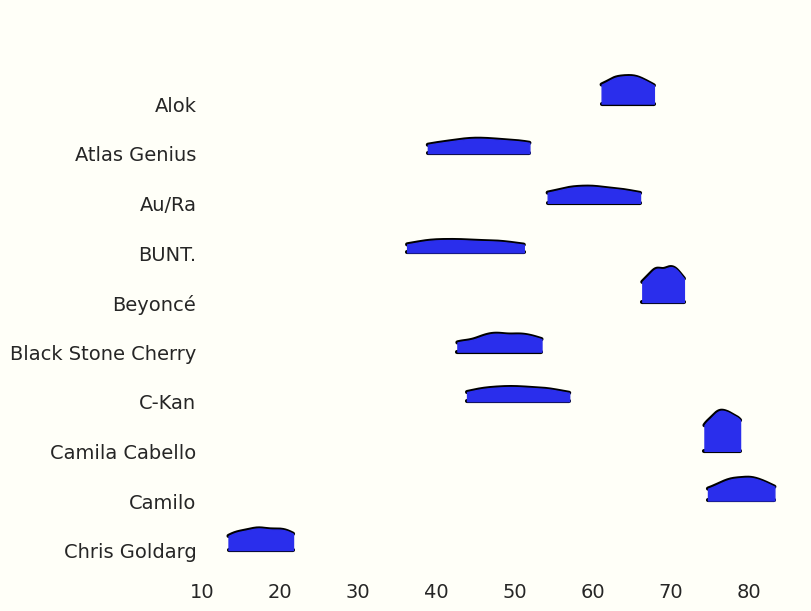

In [16]:
#combined=True implies that we get a single plot for each artist, having merged the samples of the different chains referring to the same artist.
#axes = az.plot_forest (trace_unpooled,  kind='ridgeplot', hdi_prob=0.68, var_names="mu_artist", combined=True, figsize=(8,12))

#MF_ans: 

# One way to plot labels: change the coordinates of the internal xarray array with the posterior samples
#posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
#az.plot_forest (posterior,  kind='ridgeplot', hdi_prob=0.68, var_names="mu_artist", combined=True, figsize=(8,12));

# Another way to plot labels: hack the generated matplotlib axes object
#axes = az.plot_forest (trace_unpooled,  kind='ridgeplot', hdi_prob=0.68, var_names="mu_artist", combined=True, figsize=(8,12))
#axes[0].set_yticklabels(artists[::-1]);


#MF_ans: to show only the first 10 artists we could do something like 
# To limit the output: we can use the coords option. Could also be done with the modified xarray object...
axes = az.plot_forest (trace_unpooled,
                       kind='ridgeplot',
                       hdi_prob=0.68,
                       var_names="mu_artist",
                       combined=True,
                       coords={"mu_artist_dim_0": range(10)},
                       figsize=(8, 6))
artists_10 = artists[:10]
axes[0].set_yticklabels(artists_10[::-1]);

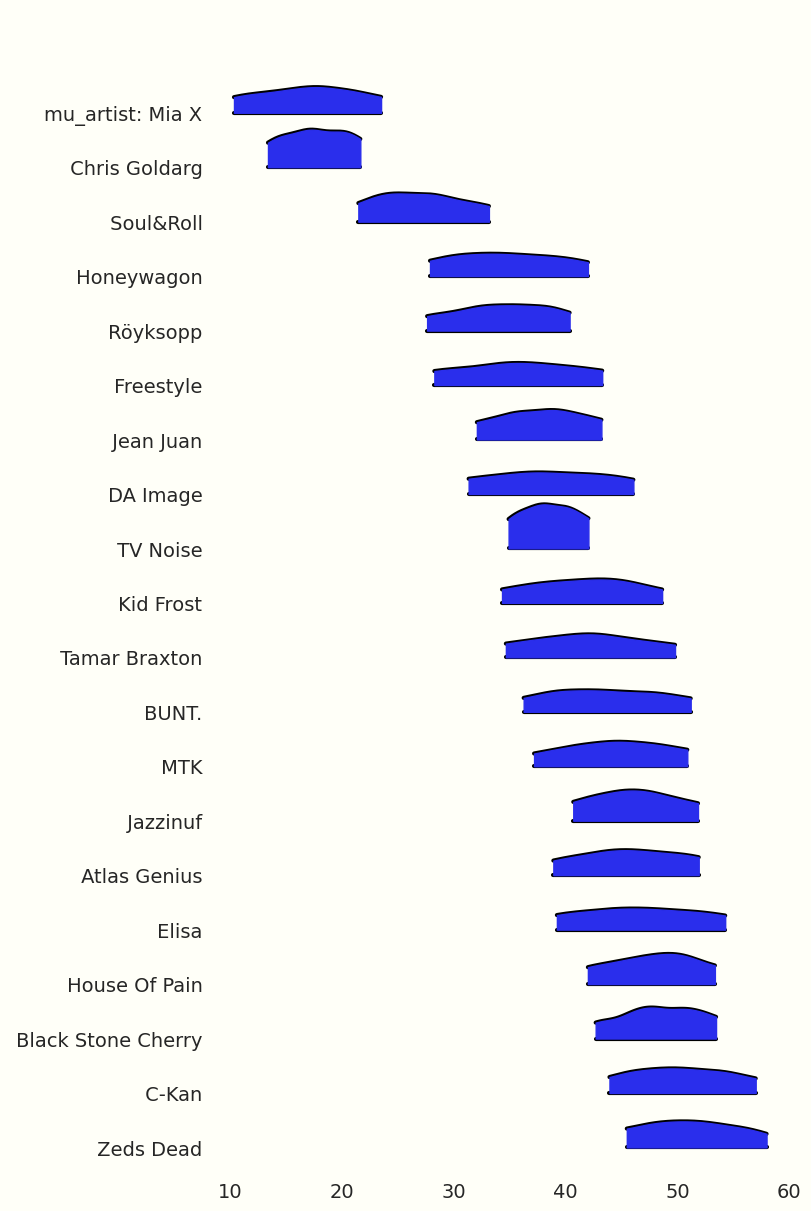

In [17]:
# MF_ans: if you meant the first 10 artists sorted in some way this is a possibility
trace_unpooled_ = trace_unpooled.copy()
trace_unpooled_.posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
artist_means = trace_unpooled_.posterior["mu_artist"].mean(("chain", "draw"))
sorted_artists = trace_unpooled_.posterior["mu_artist_dim_0"].sortby(artist_means, ascending=True)
axes = az.plot_forest(trace_unpooled_,
                       kind='ridgeplot',
                       hdi_prob=0.68,
                       var_names="mu_artist",
                       combined=True,
                       figsize=(8,12),
                       coords={"mu_artist_dim_0": sorted_artists[0:20]}
                      )

# Discussion

* The no pooled allows some artists to be more popular than others.



* Yet, it  does not model the *population* of  artists. Even though we have analyzed 44 artist, it is unable to say anything about a novel artist not yet present in the sample.



* Some estimates   are also problematic as even the 68% prediction interval is rather large; those are artist with few published songs.


* For example, our low posterior predictions for Mia X’s next song were based on a measly 4 songs. The other artists’ data suggests that these low ratings might just be a tough break – her next song might be more popular! Similarly, our high posterior predictions for Lil Skies’ next song were based on only 3 songs. In light of the other artists’ data, we might wonder whether this was beginner’s luck that will be tough to maintain.

# Hierarchical model

\begin{equation}
\begin{array}{lrl}
\text{Layer 1:} & \hspace{-0.05in} y_{ij} | \mu_j, \sigma_y   & \hspace{-0.075in} \sim \text{model of how song popularity varies WITHIN artist } j \\
\text{Layer 2:} & \hspace{-0.05in} \mu_j | \mu, \sigma_\mu & \hspace{-0.075in} \sim \text{model of how the typical popularity $\mu_j$ varies BETWEEN artists}\\
\text{Layer 3:} & \hspace{-0.05in} \mu, \sigma, \sigma_\mu  & \hspace{-0.075in} \sim \text{prior models for shared global parameters} \\
\end{array}
\end{equation}

# Level 1: individual songs for each artist.

* For  artist $j$, we assume that the popularity of songs $i$ is normally distributed with mean $μ_j$ and standard deviation $σ_y$


*  $σ_y$ is assumed to be equal for all artistist; it expresses the spread in popularity between songs of the same artist


* This is the likelihood of the model.


$$  y_{ij} | \mu_j, \sigma_y \sim N(\mu_j, \sigma_y) $$

# Level 2: modeling the population of artists


* Here we model the distribution of the $\mu_j$'s.


* The no-pooled model assign the same prior to each $\mu_j$, without any further complication.


* The hierarchical model is different, as it assumes  the 44  artists to be drawn from the population of Spotify artists. 


* Hence  $μ_j$ is drawn from a population representing the distribution of  the mean popularity of artists:
$$ \mu_j \sim N(\mu', \sigma_{\mu}) $$

# Modeling the population of artists

$$ \mu_j \sim N(\mu', \sigma_{\mu}) $$


* $\mu'$ :   average popularity within the population of artists


* $\sigma_\mu$ :  standard deviation of popularity within the population of  artists.


* We want to learn the population of artists, and hence both $\mu'$ and $\sigma_{\mu}$ are modelled as *parameters*, to which we assign a prior.

# Notation alert

* Notice the  difference between $μ_j$ (mean of the j-th artist) and $\mu$ (mean of the population of artists).


* When a parameter has a subscript $j$, it refers to a group $j$; when it has no subscript, it is global, i.e., it refers to  the whole population of artists.


* $\sigma_y$ refers to the standard deviation of $y$ values within each group. 


* $\sigma_{\mu}$ refers to the standard deviation of the means $\mu_j$ within the population of artists.

# Level 3: priors for the global parameters $\mu, \sigma_{\mu}, \sigma_y$

\begin{align*}
\mu'           & \sim N(50, 20) & \text{(implies a range of +- 60 around 50)} \\
\sigma_y      & \sim \text{Half Normal}(15) & \text{(discussed in next slide)}     & \\
\sigma_\mu & \sim \text{Half Normal}(6)    & \text{(uncertainty in the location of the global mean)}  \\
\end{align*}

In [18]:
# how to choose the priors on sigma_y
# assume that the popularity of the songs of a  given artist (sigma_y) span a range of about 50 point
# 50 / 3 is around 17, which is a plausible though large value of sigma.
# We make sure that our half normal prior covers values which are also quite far from this guess.
# To check that our prior is sensible, we sample 10000 values from the prior and checks the distribution.
# Below we implement the halfNormal as the abs of random normal.

pd.DataFrame(np.abs(np.random.normal(0, scale=15, size=10000))).describe()

,0
count,10000.000000
mean,11.911429
std,9.067189
min,0.001543
25%,4.724895
50%,9.951802
75%,17.021071
max,56.488759


In [19]:
# how to choose the priors on sigma_mu
# We assume the mean popularity to lie in a region of +- 20 points around 50.
# Thus the interval of 3 sigma should be around 20, that is sigma about 7.
# As a cross-check the mean popularity in the sample is indeed 58.
# A possible choice is given below
pd.DataFrame(np.abs(np.random.normal(0, scale=6, size=10000))).describe(percentiles=[0.50, 0.75, 0.95])

,0
count,10000.000000
mean,4.744310
std,3.537000
min,0.000399
50%,4.074542
75%,6.858755
95%,11.509267
max,21.953254


In [20]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model:
    
    # layer 1: prior on the parameters of the population of artists (hyper-priors). 
    # prior beliefs about the location of the mean popularity within the population of artists
    mu_p          = pm.Normal ('mu_p', 50,  20)
    sigma_mu = pm.HalfNormal ('sigma_mu', 6)
    sigma_y      = pm.HalfNormal ('sigma', 15)

    
    # layer 2: model of the population of artists.
    mu_artist  =  pm.Normal ('mu_artist', mu_p,  sigma_mu, shape= n_artist)
    sigma_y     = pm.HalfNormal ('sigma_y', sd = sigma_y)

    #layer 3 (observation specific for each artist)
    popularity    =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = sigma_y, observed = spotify["popularity"])
    
    trace_hier    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, mu_artist, sigma, sigma_mu, mu_p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


# Before analyzing the model results, let us think a little bit more..

# Grouping variable or covariate?

* Suppose our dataset includes a categorical variable  for which we have multiple observations per category. 


* Should $X$  be hierarchically modeled or treated as a categorical covariate?

    *   if the observed data on $X$ covers all categories of interest, it is  better treated as a covariate
    
    *  if the observed categories is a random sample from many of interest, it is a potential grouping variable.


* Our data set includes only  44 among thousands of artists on Spotify. Hence, treating artist as a predictor (as in the no pooled model) would limit our understanding to only this small number artists.



* In contrast, treating it as a grouping variable (as in the hierarchical model) allows us to not only learn about the 44 artists in our data, but the broader population of artists from which they were sampled.


# Grouping variable or covariate?

* Consider a daily data set of bike-sharing covering two years; for each day we know whether it was a weekday or a weekend.

* Is the weekend variable a grouping variable or  a covariate?

    * There are only two possible categories: weekend and weekday.
    * The dataset covers both categories, with many observations for each category.
    * Hence  it is a covariate.

# Grouping variable or covariate?

* Consider a data set containing math scores  from a sample of 10 Swiss primary schools. 


* We thus have multiple students for each `school_id`.


* These 10 schools are merely a small sample from the hundreds  of Swiss primary schools.
    * The `school_id`, treated as a covariate (unpooled model) would only allow us to learn about our small sample of schools.
    * Treating it as a grouping variable in a hierarchical model  would allow us to extend our conclusions to the broader population of all schools.
    
    
* The same consideration applies if you want to analyze e.g. data of a certain disease collected by different hospitals, in which case the involved hospitals can be modelled as a grouping variable.

# Grouping variable or covariate

* In some cases the decision is not clear-cut. For instance you might have a categorical variable with different levels; for some of them many observations are available, for some other levels the number of observations is reduced.

* In this case you might fit both models, and eventually choose according to WAIC.

* WAIC is a model selection criterion, to be discussed more in detail later. For the moment, it is enough to know that we choose we model with lowest WAIC.

# Conceptual exercise: modelling fuel prices

* Define a hierarchical model for the fuel price which considers  different stations located in the same area over a period of e.g. one year.


 * Thus $y_{ij}$ is the price of gas at the $j$-th station in the $i$-th day.


*  Discuss the meaning of all model parameters ( $\mu_j$, $\sigma_y$, $\mu$, $\sigma_{\mu}$).


*  Write the probabilistic, assigning sensible priors based on your experience.    

# Back to the numerical example of Spotify

# Parameters
* The hierarchical Spotify model  has  47 parameters:
    * 44 artist-specific parameters $\mu_j$
    * 3 global parameters $\mu', \sigma_y,  \sigma_\mu\$.

In [21]:
az.summary(trace_hier, var_names=["mu_p", "sigma_y", "sigma", "mu_artist"])[["mean","hdi_3%","hdi_97%","r_hat"]].head()

,mean,hdi_3%,hdi_97%,r_hat
mu_p,52.430,47.781,56.638,1.0
sigma_y,14.025,12.983,15.044,1.0
sigma,15.886,5.276,29.619,1.0
mu_artist[0],64.203,58.139,69.905,1.0
mu_artist[1],47.142,35.483,58.673,1.0


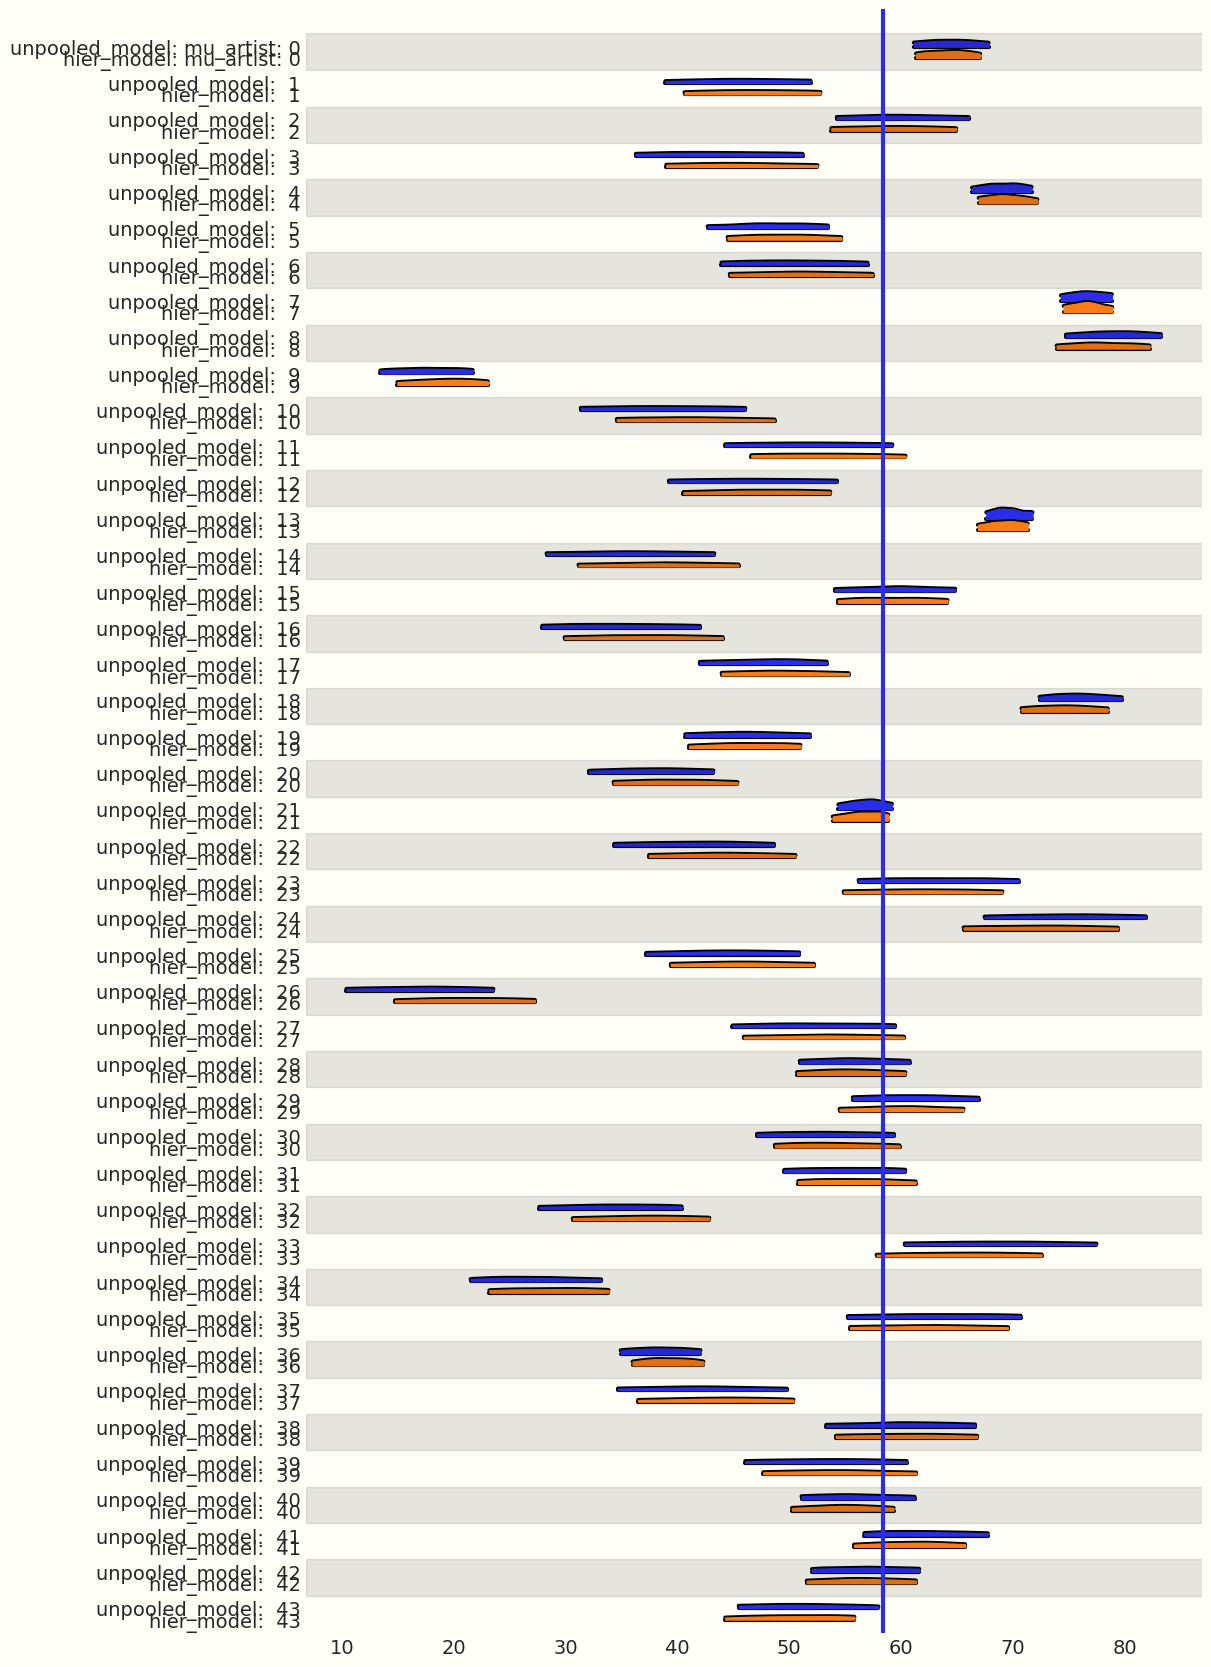

In [22]:
#plotting the estimated popularity of each artist, according to the unpooled and to the hierarhical model
#MF: in a more refined implementation it would be nice to show the artist name on the y axis, and perhaps limit the graph only to the first 20 artists
# to have a more readable plot, we use a rather short 68% hdi, corresponding to +-1sigma around the mean
axes = az.plot_forest([trace_unpooled, trace_hier], 
                      model_names=['unpooled_model', 'hier_model'], combined=True, kind='ridgeplot', var_names='mu_artist', hdi_prob=0.68);

#mean popularity of all songs
grand_mean = spotify["popularity"].mean()
axes[0].axvline(x=grand_mean);

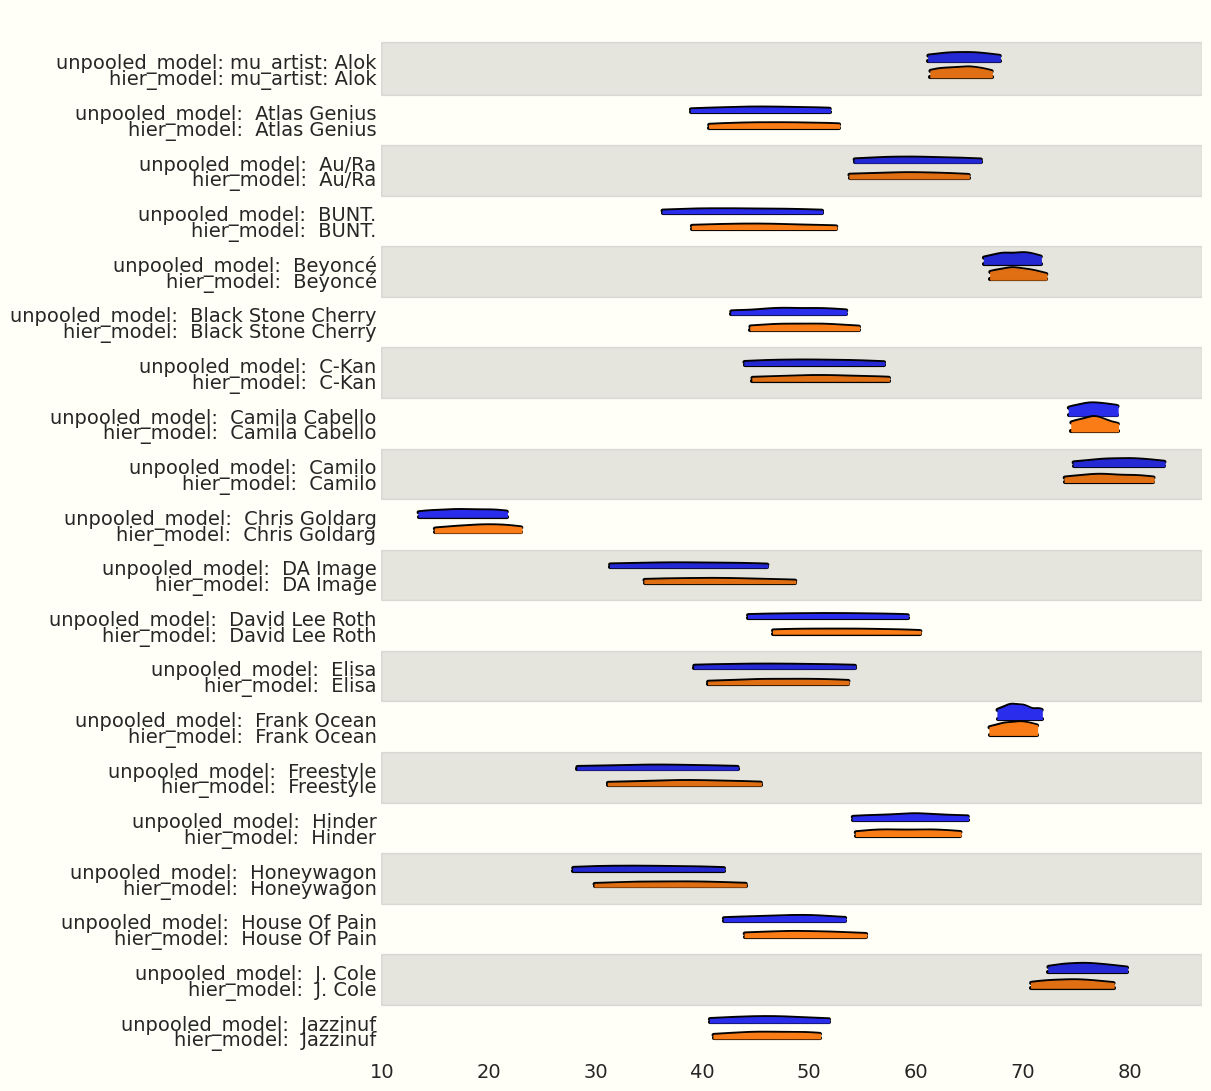

In [23]:
#MF_ans:
# The easiest is perhaps to change the coordinates of the inner xarray.  

trace_unpooled_ = trace_unpooled.copy() # just to avoid touching the existing objects
trace_unpooled_.posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)

trace_hier_ = trace_hier.copy()
trace_hier_.posterior = trace_hier.posterior.assign_coords(mu_artist_dim_0=artists)

axes = az.plot_forest([trace_unpooled_, trace_hier_], 
                      model_names=['unpooled_model', 'hier_model'],
                      combined=True, kind='ridgeplot',
                      var_names='mu_artist',
                      hdi_prob=0.68,
                      coords={"mu_artist_dim_0": artists[0:20]});
                      #coords={"mu_artist_dim_0": sorted_artists[0:20]});

In [30]:
#MF_ans: Another solution hacking the axes labels could also be possible (not tried)
axes[0].get_yticklabels()

[Text(0, 0.0, 'hier_model:  Jazzinuf'),
 Text(0, 2.25, 'unpooled_model:  Jazzinuf'),
 Text(0, 7.2, 'hier_model:  J. Cole'),
 Text(0, 9.45, 'unpooled_model:  J. Cole'),
 Text(0, 14.399999999999999, 'hier_model:  House Of Pain'),
 Text(0, 16.65, 'unpooled_model:  House Of Pain'),
 Text(0, 21.599999999999998, 'hier_model:  Honeywagon'),
 Text(0, 23.849999999999998, 'unpooled_model:  Honeywagon'),
 Text(0, 28.799999999999997, 'hier_model:  Hinder'),
 Text(0, 31.049999999999997, 'unpooled_model:  Hinder'),
 Text(0, 36.0, 'hier_model:  Freestyle'),
 Text(0, 38.25, 'unpooled_model:  Freestyle'),
 Text(0, 43.2, 'hier_model:  Frank Ocean'),
 Text(0, 45.45, 'unpooled_model:  Frank Ocean'),
 Text(0, 50.400000000000006, 'hier_model:  Elisa'),
 Text(0, 52.650000000000006, 'unpooled_model:  Elisa'),
 Text(0, 57.60000000000001, 'hier_model:  David Lee Roth'),
 Text(0, 59.85000000000001, 'unpooled_model:  David Lee Roth'),
 Text(0, 64.80000000000001, 'hier_model:  DA Image'),
 Text(0, 67.0500000000000

# Shrinkage: pulling the estimates towards the grand mean

*  The pooled  model ignores the fact that our data is grouped by artist;  the  posterior mean popularity was the same for each artist, which is roughly equivalent to the grand mean (i.e., the mean popularity of the 350 songs)


*  The unpooled model separately analyzes each artist;  its predictive means are roughly equivalent to the sample mean popularity of  each artist.


* In both cases, the estimates are regularized by the prior, hence they are not truly identical to the sample means


* The hierarchical models is a more sophisticated approach. It pulls  (or *shrunk*) the predictions of the unpooled model  toward the global trends of the pooled model.


# Shrinkage

* It the variances $\sigma^2_y$ and  $\sigma^2_{\mu}$ are fixed and known, the posterior mean computed by the hierarchical model for  artist $j$  is: 

$$
\overline{y}_{j,\text{hier}} =
\underbrace{
\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_{\mu}}
}_{\text{weight of the global model}}
\overline{y}_{\text{global}} + 
\underbrace{
\frac{n_j\sigma^2_{\mu}}{\sigma^2_y + n_j \sigma^2_{\mu}}
}_{\text{weight of the local model}}
\overline{y}_j
$$


* This is not our case, as we treat both variances as parameters. Yet, we can use  the above formula to understand *shrinkage*.

* The weight of   local model increases when we have more data ($n_j$) about artist $j$.
* The weights also depend on $\sigma_y$: the larger $\sigma_y$ and hence the variability of popularity for the same artist, the larger the weight of the global model (we cannot trust much the means  $\overline{y}_j$).

* Scenarios in which the hierarchical posterior predictions shrinks towards the global mean:
     * when  $n_j$ is low:  we rely more on global trends to understand a group for which we have little data.
     *  when the variability of popularity for songs of the same artist ($\sigma_y$) is large in comparison to the variability the mean populatrity of the artists $\sigma_{\mu}$.
     * If the models learns that  artist are very similar to each other ($\sigma_{\mu}$ is low), it increases the weight of the pooled model.

In [24]:
# MF: si puo' MOSTRARE INTENSITA DELLO SHRINKAGE IN FUNZIONE DI n_j??
# measuring shrinkage as a function of $n_j$

n_j=spotify['artist'].value_counts(sort=False)


#posterior mean according to the unpooled model
mean_unpooled = pd.Series(az.summary(trace_unpooled, var_names='mean')["mean"], index=n_j.index)

#posterior mean according to the hier model
mean_hier = az.summary(trace_hier, var_names='mean')["mean"]

shrinkage= pd.Series (mean_hier-mean_unpooled, index=n_j.index)

type(n_j)
#df= pd.concat([mean_unpooled - mean_hier, n_j])


KeyError: 'var names: "[\'mean\'] are not present" in dataset'

# Discussion

* Consider the complete pooled model. By pooling all cases together, this model is very rigid and won’t vary much if based on a different sample of Spotify artists. BUT it also tends to be overly simple and miss the nuances in artists’ mean popularity  Thus, complete pooled models tend to have higher bias and lower variance.


* No pooled models have the opposite problem. With the built-in flexibility to detect group-specific trends, they tend to have less bias than complete pooled models. BUT, since they’re tailored to the artists in our sample, if we sampled a different set of Spotify artists our no pooled models could change quite a bit, and thus produce unstable conclusions. Thus, no pooled models tend to have lower bias and higher variance.


* Hierarchical models offer a balanced alternative. Unlike complete pooled models, hierarchical models take group-specific trends into account, and thus will be less biased. And unlike no pooled models, hierarchical models take global trends into account, and thus will be less variable. Hierarchical models!

# Probabilistic prediction  for the popularity of the next song produced by a specific artist.

* Let us consider e.g. artist n. 25.

* Assuming to access the sample of the trace, our prediction about the popularity of the next song by artist 25 is done simulating, for each sample $s$,: 
 $$y_{25,s}^{new} \sim N( \mu_{25,s}, \sigma_{y,s}) $$
 
 * Implement the prediction and check the consistency of the results by:
     * using the samples from the trace
     * implementing the prediction within the pymc3 model

# Predicting the popularity of a new artist


* Write a pseudo-code to predict the popularity of the first  song of a novel artist.


* Implement the prediction

In [ ]:
# prediction of the popularity of a new song for artist 25 by  accessing the trace

a = az.extract_dataset(trace_hier)
y_new_25 = np.random.normal (loc = a["mu_artist"][25],  scale = a["sigma_y"])
pd.DataFrame(y_new_25).describe(percentiles=[0.03,0.97])

# a very few sampled data are negative. Can you trace the reason of this problem and provide a solution?

In [ ]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model_with_preds:
    
    # layer 1: prior on the parameters of the population of artists (hyper-priors). 
    # prior beliefs about the location of the mean popularity within the population of artists
    mu_population          = pm.Normal ('mu_p', 50,  20)
    sigma_mu = pm.HalfNormal ('sigma_mu', 6)
    sigma_y      = pm.HalfNormal ('sigma', 15)

    
    # layer 2: model of the population of artists.
    mu_artist  =  pm.Normal ('mu_artist', mu_population,  sigma_mu, shape= n_artist)
    sigma_y     = pm.HalfNormal ('sigma_y', sd = sigma_y)

    #layer 3 (observation specific for each artist)
    popularity    =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = sigma_y, observed = spotify["popularity"])
    
    # == PREDICTIONS
    #prediction of popularity for the next song of  artist 25
    prediction_artist25 = pm.Normal('prediction_artist25', mu = mu_artist[25],  sigma = sigma_y)
    
    #prediction of popularity for a song from a  novel artist. This requires two steps.
    # step 1:  sample the popularity mu_j of the new artist, by sampling from the population of artists.
    mu_new_artist = pm.Normal('new_mean', mu=mu_population, sigma=sigma_mu)
    # step 2:  sample the popularity of a song using the sampled values mu_j for the unknown artist popularity
    prediction_new_artist = pm.Normal('prediction_new_artist', mu = mu_new_artist,  sigma = sigma_y)
    
    trace_hier_with_preds   = pm.sample(return_inferencedata=True)

In [ ]:
# notice the substamtial uncertainty for the prediction of the new artist
az.summary(trace_hier_with_preds, var_names=['prediction_artist25', 'prediction_new_artist'])

# Conceptual exercise 

* Four friends take a  speed-typing tests. Each person repeat 20 times the typing of a certain word.

* Let $y_{ij}$ be the time it takes friend $j$ to complete test $i$.


1) Formalize  a hierarchical model, discussing  the meaning of all model parameters: ($μ_j, μ, \sigma_y, \sigma_{\mu}$)

    
2) Consider the following scenarios and discuss their effect on the posterior distribution of the parameters:

    * The overall results of the 20 timed tests are remarkably similar among the four friends.
    * Each person is quite consistent in their typing times, but there are big differences from person to person – some tend to type much faster than others.
   * Within the subjects, there doesn’t appear to be much correlation in typing time from test to test.

* For each scenario, indicate whether:
* $ σ_y<σ_μ$. 
* $ σ_y≈σ_μ$. 
* $ σ_y>σ_μ$. 